# Human Pose Estimation on Leeds Sports Pose (LSP) Dataset

## Imports

Install and import package containing the LSP dataset

In [ ]:
%%capture
!pip install deeplake
import deeplake

import other used packages

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
import cv2
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor


import io
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import numpy as np
from torchvision.transforms import functional as F

from PIL import Image
import matplotlib.pyplot as plt


import time
import math
from google.colab import files

## Data loading and preparation

Loading data

In [ ]:
test = deeplake.load("hub://activeloop/lsp-test")
train = deeplake.load("hub://activeloop/lsp-train")

\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test



-

hub://activeloop/lsp-test loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



\

hub://activeloop/lsp-train loaded successfully.



Defining joints in the dataset and their connection to form the skeleton for visualization

In [ ]:
joints = ["Right ankle", "Right knee", "Right hip", "Left hip", "Left knee", "Left ankle", "Right wrist", "Right elbow", "Right shoulder", "Left shoulder", "Left elbow", "Left wrist", "Neck", "Head top"]
skeleton = [[0,1],[1,2],[2,3],[3,4],[4,5],[6,7],[7,8],[9,10],[10,11],[8,12],[9,12],[12,13]]

Trasforming data to dictionary structure

In [ ]:
LSP_train = {"images": train["images"][:].numpy(aslist = True),
             "joints": train["keypoints"][:].numpy(aslist = True),
             "images_visualized": train["images_visualized"][:].numpy(aslist = True)}

LSP_test = {"images": test["images"][:].numpy(aslist = True),
            "joints": test["keypoints"][:].numpy(aslist = True),
            "images_visualized": test["images_visualized"][:].numpy(aslist = True)}

Rescaling joints to same size as original images

In [ ]:
# Converting list to np array
LSP_train["joints"] = np.asarray(LSP_train["joints"])
LSP_test["joints"] = np.asarray(LSP_test["joints"])

# The X and Y scaling factor is 0.566 on average (from larger visualized to smaller originals)
LSP_train["joints"] = LSP_train["joints"][:, :, 0: 2] * 0.566
LSP_test["joints"] = LSP_test["joints"][:, :, 0: 2] * 0.566

Showing example of an image with joint position

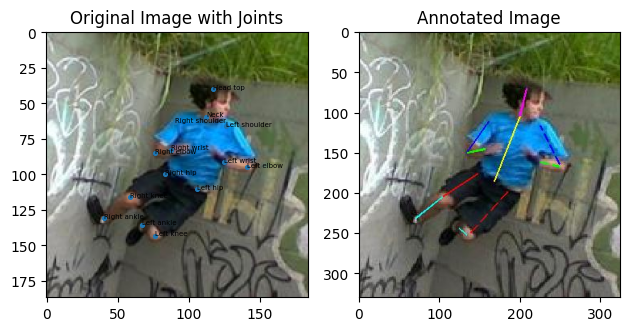

In [ ]:
#Change num to affect visualizing original and normalized example
picture_num = 1

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

ax1.imshow(LSP_test["images"][picture_num])
ax1.scatter(LSP_test["joints"][picture_num, :, 0], LSP_test["joints"][picture_num, :, 1], s = 7)
ax1.set_title("Original Image with Joints")

ax2.imshow(LSP_test["images_visualized"][picture_num])
ax2.set_title("Annotated Image")

for pos, joint in enumerate(joints):
  ax1.annotate(joint, (LSP_test["joints"][picture_num, :, 0][pos], LSP_test["joints"][picture_num, :, 1][pos]),
               fontsize = 5)

fig.tight_layout()

Resizing images and joints to a new size

In [ ]:
# Resize
new_size = (256,256)

# TRAIN
for pos in range(1000):
  x_scale = new_size[0] / LSP_train["images"][pos].shape[1]
  y_scale = new_size[1] / LSP_train["images"][pos].shape[0]

  LSP_train["joints"][pos] *= [x_scale, y_scale]

# TEST
for pos in range(1000):
  x_scale = new_size[0] / LSP_test["images"][pos].shape[1]
  y_scale = new_size[1] / LSP_test["images"][pos].shape[0]

  LSP_test["joints"][pos] *= [x_scale, y_scale]

In [ ]:
for pos in range(1000):
  LSP_train["images"][pos] = cv2.resize(LSP_train["images"][pos], new_size)

LSP_train["images"] = np.asarray(LSP_train["images"])

# TEST
for pos in range(1000):
  LSP_test["images"][pos] = cv2.resize(LSP_test["images"][pos], new_size)

LSP_test["images"] = np.asarray(LSP_test["images"])

Plot with new size

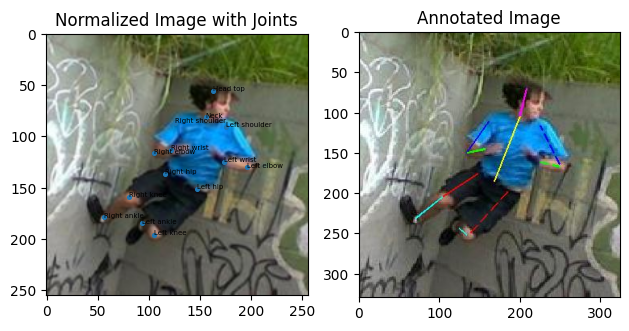

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

ax1.imshow(LSP_test["images"][picture_num])
ax1.scatter(LSP_test["joints"][picture_num, :, 0], LSP_test["joints"][picture_num, :, 1], s = 7)
ax1.set_title("Normalized Image with Joints")

ax2.imshow(LSP_test["images_visualized"][picture_num])
ax2.set_title("Annotated Image")

for pos, joint in enumerate(joints):
  ax1.annotate(joint, (LSP_test["joints"][picture_num, :, 0][pos], LSP_test["joints"][picture_num, :, 1][pos]),
               fontsize = 5)

fig.tight_layout()

## Model definition

Our model is based on the [Simple Baseline for Human Position and Tracking](https://github.com/microsoft/human-pose-estimation.pytorch) model

In [ ]:
train = LSP_train
test = LSP_test

Defining parameters used to construct model

In [ ]:
DEC_LAYERS = 3
DEC_FILTERS = [256, 256, 256]
DEC_KERNELS = [4, 4, 4]
NUM_JOINTS = len(joints)
FINAL_CONV_KERNEL = 3
IMAGE_SIZE = [256, 256]
HEATMAP_SIZE = [64, 64]

Define class for the data, includes a function to return an heatmap generated from ground truth joints

In [ ]:
class LSPDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.sigma = 2
        self.heatmap_size = HEATMAP_SIZE
        self.num_joints = NUM_JOINTS
        self.image_size = IMAGE_SIZE

    def __len__(self):
        return len(self.dataset['images'])

    def __getitem__(self, idx):
        # Convert deeplake tensor to numpy array, then to PIL Image
        image = Image.fromarray(np.array(self.dataset['images'][idx]))

        joints = self.dataset['joints'][idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        target = self.generate_target(joints)
        target = torch.from_numpy(target)

        return image, target, joints

    def generate_target(self, joints): #removed visibility and weights
        target = np.zeros((self.num_joints,
                            self.heatmap_size[1],
                            self.heatmap_size[0]),
                          dtype=np.float32)

        tmp_size = self.sigma * 3

        for joint_id in range(self.num_joints):
            feat_stride = [self.image_size[ind] / self.heatmap_size[ind] for ind in range(len(self.image_size))]
            mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
            mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
            ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
            br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

            # # Generate gaussian
            size = 2 * tmp_size + 1
            x = np.arange(0, size, 1, np.float32)
            y = x[:, np.newaxis]
            x0 = y0 = size // 2
            # The gaussian is not normalized, we want the center value to equal 1
            g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * self.sigma ** 2))

            # Usable gaussian range
            g_x = max(0, -ul[0]), min(br[0], self.heatmap_size[0]) - ul[0]
            g_y = max(0, -ul[1]), min(br[1], self.heatmap_size[1]) - ul[1]
            # Image range
            img_x = max(0, ul[0]), min(br[0], self.heatmap_size[0])
            img_y = max(0, ul[1]), min(br[1], self.heatmap_size[1])
            target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

        return target

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
    # Add any other transformations as needed
])

Define dataloader

In [ ]:
# data loading
# Create the dataset with the transform
train_dataset = LSPDataset(train, transform=transform)
test_dataset = LSPDataset(test, transform=transform)

# Create data loaders
batch_size = 32  # You can modify this based on your GPU capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Define custom Loss, defined as MSELoss between prediction heatmaps and heatmaps generated from ground truth for each joint

In [ ]:
class JointsMSELoss(nn.Module):
    def __init__(self):
        super(JointsMSELoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, output, target, epoch):
        batch_size = output.size(0)
        num_joints = output.size(1)
        #ADDED: multiplying for 100/epoch to quickstart start the learning
        heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).mul(100/(epoch+1)).split(1, 1)
        loss = 0

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints

Defining class to keep count of average data during training and testing

In [ ]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count if self.count != 0 else 0

Defining functions to calculate distances and PCK accuracy

In [ ]:
def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1


def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output)
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return acc, avg_acc, cnt, pred

Defining function to return the predicted coordinate for each joint, based on heatmaps

In [ ]:
def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals

Defining function to save an image containing joints' ground truth and predicted joints position

In [ ]:
def save_image(batch_image, batch_joints, batch_joints_pred, file_name="saved_imgs.jpg",
               nrow=8, padding=2):
    grid = torchvision.utils.make_grid(batch_image, nrow, padding, True)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    ndarr = ndarr.copy()

    nmaps = batch_image.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height = int(batch_image.size(2) + padding)
    width = int(batch_image.size(3) + padding)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            joints = batch_joints[k]
            joints_pred = batch_joints_pred[k]

            for joint, joint_pred in zip(joints, joints_pred):
                joint[0] = x * width + padding + joint[0]
                joint[1] = y * height + padding + joint[1]
                cv2.circle(ndarr, (int(joint[0]), int(joint[1])), 2, [0, 255, 0], 2)
                joint_pred[0] = x * width + padding + joint_pred[0]
                joint_pred[1] = y * height + padding + joint_pred[1]
                cv2.circle(ndarr, (int(joint_pred[0]), int(joint_pred[1])), 2, [0, 0, 255], 2)

            k = k + 1
    cv2.imwrite(file_name, ndarr)

Defining function to save an image containing heatmaps for each joint

In [ ]:
def save_batch_heatmaps(batch_image, batch_heatmaps, file_name="heatmap_saved_imgs.jpg",
                        normalize=True):
    '''
    batch_image: [batch_size, channel, height, width]
    batch_heatmaps: ['batch_size, num_joints, height, width]
    file_name: saved file name
    '''
    if normalize:
        batch_image = batch_image.clone()
        min = float(batch_image.min())
        max = float(batch_image.max())

        batch_image.add_(-min).div_(max - min + 1e-5)

    batch_size = batch_heatmaps.size(0)
    num_joints = batch_heatmaps.size(1)
    heatmap_height = batch_heatmaps.size(2)
    heatmap_width = batch_heatmaps.size(3)

    grid_image = np.zeros((batch_size*heatmap_height,
                           (num_joints+1)*heatmap_width,
                           3),
                          dtype=np.uint8)

    preds, maxvals = get_max_preds(batch_heatmaps.detach().cpu().numpy())

    for i in range(batch_size):
        image = batch_image[i].mul(255)\
                              .clamp(0, 255)\
                              .byte()\
                              .permute(1, 2, 0)\
                              .cpu().numpy()
        heatmaps = batch_heatmaps[i].mul(255)\
                                    .clamp(0, 255)\
                                    .byte()\
                                    .cpu().numpy()

        resized_image = cv2.resize(image,
                                   (int(heatmap_width), int(heatmap_height)))

        height_begin = heatmap_height * i
        height_end = heatmap_height * (i + 1)
        for j in range(num_joints):
            cv2.circle(resized_image,
                       (int(preds[i][j][0]), int(preds[i][j][1])),
                       1, [0, 0, 255], 1)
            heatmap = heatmaps[j, :, :]
            colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            masked_image = colored_heatmap*0.7 + resized_image*0.3
            cv2.circle(masked_image,(int(preds[i][j][0]), int(preds[i][j][1])),1, [0, 0, 255], 1)

            width_begin = heatmap_width * (j+1)
            width_end = heatmap_width * (j+2)
            grid_image[height_begin:height_end, width_begin:width_end, :] = \
                masked_image
            # grid_image[height_begin:height_end, width_begin:width_end, :] = \
            #     colored_heatmap*0.7 + resized_image*0.3

        grid_image[height_begin:height_end, 0:heatmap_width, :] = resized_image

    cv2.imwrite(file_name, grid_image)

Defining training function that performs one epoch of training, it saves images for heatmaps and point predictions, and returns an object containing the average accuracy (total and for each joint) in the training epoch.

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq = 4):
  batch_time = AverageMeter()
  data_time = AverageMeter()
  losses = AverageMeter()
  acc = AverageMeter()
  acc_tot = list()
  for j in range(NUM_JOINTS+1):
    acc_tot.append(AverageMeter())

  # switch to train mode
  model.train()

  end = time.time()
  for i, (input, target, joints) in enumerate(train_loader): #removed target_weight and meta from train_loader
    # measure data loading time
    data_time.update(time.time() - end)

    # compute output
    output = model(input).cuda()
    target = target.cuda(non_blocking=True)

    loss = criterion(output, target, epoch)

    # compute gradient and do update step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure accuracy and record loss
    losses.update(loss.item(), input.size(0))

    acc_all, avg_acc, cnt, pred = accuracy(output.detach().cpu().numpy(),
                                      target.detach().cpu().numpy())
    acc.update(avg_acc, cnt)
    for j in range(NUM_JOINTS+1):
      acc_tot[j].update(acc_all[j],cnt)

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

    if i % print_freq == 0:
      msg = 'Epoch: [{0}][{1}/{2}]\t' \
            'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
            'Speed {speed:.1f} samples/s\t' \
            'Loss {loss.val:.5f} ({loss.avg:.5f})\t' \
            'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                speed=input.size(0)/batch_time.val, loss=losses, acc=acc)
      print(msg)
      save_image(input, joints, pred*4, file_name="train_joints_"+str(epoch)+"_"+str(i)+".jpg")
      save_batch_heatmaps(input, target, file_name="train_heatmap_"+str(epoch)+"_"+str(i)+".jpg")
      save_batch_heatmaps(input, output, file_name="train_pred_heatmap_"+str(epoch)+"_"+str(i)+".jpg")
  return acc_tot

Defining validation (testing) function, it saves images for heatmaps and point predictions for all data loaded, it returns the predicted heatmaps and an object containing the average accuracy (total and for each joint).

In [ ]:
#gotta check
def validate(val_loader, val_dataset, model, criterion, print_freq=1):
  batch_time = AverageMeter()
  losses = AverageMeter()
  acc = AverageMeter()
  acc_tot = list()
  for j in range(NUM_JOINTS+1):
    acc_tot.append(AverageMeter())

  # switch to evaluate mode
  model.eval()

  num_samples = len(val_dataset)
  all_preds = np.zeros((num_samples, NUM_JOINTS, 3),
                       dtype=np.float32)
  image_path = []
  filenames = []
  imgnums = []
  idx = 0
  with torch.no_grad():
    end = time.time()
    for i, (input, target, joints) in enumerate(val_loader): #removed target_weight and meta
      # compute output
      output = model(input).cuda()

      target = target.cuda(non_blocking=True)

      loss = criterion(output, target, 20)

      num_images = input.size(0)
      # measure accuracy and record loss
      losses.update(loss.item(), num_images)
      acc_all, avg_acc, cnt, pred = accuracy(output.cpu().numpy(),
                                        target.cpu().numpy())

      acc.update(avg_acc, cnt)
      for j in range(NUM_JOINTS+1):
        acc_tot[j].update(acc_all[j],cnt)

      # measure elapsed time
      batch_time.update(time.time() - end)
      end = time.time()

      preds, maxvals = get_max_preds(output.clone().cpu().numpy())

      all_preds[idx:idx + num_images, :, 0:2] = preds[:, :, 0:2]
      all_preds[idx:idx + num_images, :, 2:3] = maxvals

      idx += num_images

      if i % print_freq == 0:
        msg = 'Test: [{0}/{1}]\t' \
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
              'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                  i, len(val_loader), batch_time=batch_time,
                  loss=losses, acc=acc)
        print(msg)
      save_image(input, joints, pred*4, file_name="test_joints_"+str(i)+".jpg")
      save_batch_heatmaps(input, target, file_name="test_heatmap_"+str(i)+".jpg")
      save_batch_heatmaps(input, output, file_name="test_pred_heatmap_"+str(i)+".jpg")

    return all_preds, acc_tot

Building the model, it contains a backbone consisting of a pretrained model imported from torchvision.models with last layers removed, deconvolution layers and final convolution layer, to produce heatmaps in number equal to the number of joints in the dataset

In [ ]:
class PoseRes(nn.Module):
  def __init__(self):
    super(PoseRes, self).__init__()
    self.deconv_with_bias = False

    #backbone, inplanes are the number of output planes from the backbone, that go in deconvolution layers
    #resnet50 backbone
    self.backbone = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
    self.inplanes = 2048
    #resnet18 backbone
    #self.backbone = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
    #self.inplanes = 512
    #efficientnet_v2_s backbone
    #self.backbone = nn.Sequential(*list(models.efficientnet_v2_s(pretrained=True).children())[:-2])
    #self.inplanes = 1280
    #shufflenet backbone
    #self.backbone = nn.Sequential(*list(models.shufflenet_v2_x2_0(pretrained=True).children())[:-1])
    #self.inplanes = 2048


    self.deconv_layers = self._make_deconv_layer(
      DEC_LAYERS,
      DEC_FILTERS,
      DEC_KERNELS,
    )
    self.final_layer = nn.Conv2d(
      in_channels=DEC_FILTERS[-1],
      out_channels=NUM_JOINTS,
      kernel_size=FINAL_CONV_KERNEL,
      stride=1,
      padding=1 if FINAL_CONV_KERNEL == 3 else 0
    )

  def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
    assert num_layers == len(num_filters), \
      'ERROR: num_deconv_layers is different len(num_deconv_filters)'
    assert num_layers == len(num_kernels), \
      'ERROR: num_deconv_layers is different len(num_deconv_filters)'

    layers = []
    for i in range(num_layers):
      kernel, padding, output_padding = \
        self._get_deconv_cfg(num_kernels[i], i)

      planes = num_filters[i]
      layers.append(
        nn.ConvTranspose2d(
          in_channels=self.inplanes,
          out_channels=planes,
          kernel_size=kernel,
          stride=2,
          padding=padding,
          output_padding=output_padding,
          bias=self.deconv_with_bias))
      layers.append(nn.BatchNorm2d(planes))
      layers.append(nn.ReLU(inplace=True))
      self.inplanes = planes

    return nn.Sequential(*layers)

  def _get_deconv_cfg(self, deconv_kernel, index):
    if deconv_kernel == 4:
      padding = 1
      output_padding = 0
    elif deconv_kernel == 3:
      padding = 1
      output_padding = 1
    elif deconv_kernel == 2:
      padding = 0
      output_padding = 0

    return deconv_kernel, padding, output_padding

  def forward(self, x):
    x=self.backbone(x)
    x=self.deconv_layers(x)
    x=self.final_layer(x)
    return x

In [ ]:
model = PoseRes()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X2_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing layers in the backbone part of our model

In [ ]:
#Freeze all backbone layers except last
for param in model.backbone[:-1].parameters():
    param.requires_grad = False

#Freeze all backbone layers
#for param in model.backbone.parameters():
#    param.requires_grad = False

#Freeze all backbone layers except last for efficientnet_v2
#for param in model.backbone[0][:-1].parameters():
#    param.requires_grad = False

Choosing Loss function and optimizer

In [ ]:
criterion = JointsMSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

### Prints to check model and frozen layers

In [ ]:
print(model)

PoseRes(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(122, eps=1e

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

backbone.0.0.weight False
backbone.0.1.weight False
backbone.0.1.bias False
backbone.2.0.branch1.0.weight False
backbone.2.0.branch1.1.weight False
backbone.2.0.branch1.1.bias False
backbone.2.0.branch1.2.weight False
backbone.2.0.branch1.3.weight False
backbone.2.0.branch1.3.bias False
backbone.2.0.branch2.0.weight False
backbone.2.0.branch2.1.weight False
backbone.2.0.branch2.1.bias False
backbone.2.0.branch2.3.weight False
backbone.2.0.branch2.4.weight False
backbone.2.0.branch2.4.bias False
backbone.2.0.branch2.5.weight False
backbone.2.0.branch2.6.weight False
backbone.2.0.branch2.6.bias False
backbone.2.1.branch2.0.weight False
backbone.2.1.branch2.1.weight False
backbone.2.1.branch2.1.bias False
backbone.2.1.branch2.3.weight False
backbone.2.1.branch2.4.weight False
backbone.2.1.branch2.4.bias False
backbone.2.1.branch2.5.weight False
backbone.2.1.branch2.6.weight False
backbone.2.1.branch2.6.bias False
backbone.2.2.branch2.0.weight False
backbone.2.2.branch2.1.weight False
back

## Loading a saved model

In [ ]:
#loading function
modelname = "model_unfreezelast_resnet18_20.pth"

checkpoint = torch.load(modelname)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print("Model loaded")

Model loaded


## Training

Training can be started at any epoch, in case there is the need to load a model and continue training, here training is performed for 20 epochs

In [ ]:
#model training, can continue from a previous stop
start_epoch=0
end_epoch=5
train_acc = []
for epoch in range(start_epoch, end_epoch):
  epoch_acc = train(train_loader, model, criterion, optimizer, epoch, print_freq=8)
  accs = []
  for j in range(len(epoch_acc)):
    accs.append(epoch_acc[j].avg)
  accs.insert(0,epoch)
  train_acc.append(accs)
print('Finished Training')

Epoch: [0][0/32]	Time 9.484s (9.484s)	Speed 3.4 samples/s	Loss 15.41689 (15.41689)	Accuracy 0.022 (0.022)
Epoch: [0][8/32]	Time 7.710s (7.889s)	Speed 4.2 samples/s	Loss 14.55360 (14.91519)	Accuracy 0.083 (0.052)
Epoch: [0][16/32]	Time 7.646s (7.724s)	Speed 4.2 samples/s	Loss 14.20390 (14.65643)	Accuracy 0.145 (0.085)
Epoch: [0][24/32]	Time 7.658s (7.645s)	Speed 4.2 samples/s	Loss 13.88108 (14.45175)	Accuracy 0.179 (0.110)
Epoch: [1][0/32]	Time 7.168s (7.168s)	Speed 4.5 samples/s	Loss 3.62483 (3.62483)	Accuracy 0.268 (0.268)
Epoch: [1][8/32]	Time 7.161s (7.505s)	Speed 4.5 samples/s	Loss 3.24168 (3.37333)	Accuracy 0.337 (0.294)
Epoch: [1][16/32]	Time 7.125s (7.527s)	Speed 4.5 samples/s	Loss 3.15770 (3.28385)	Accuracy 0.337 (0.319)
Epoch: [1][24/32]	Time 7.077s (7.516s)	Speed 4.5 samples/s	Loss 3.07526 (3.23299)	Accuracy 0.382 (0.330)
Epoch: [2][0/32]	Time 7.793s (7.793s)	Speed 4.1 samples/s	Loss 1.32710 (1.32710)	Accuracy 0.464 (0.464)
Epoch: [2][8/32]	Time 7.502s (7.453s)	Speed 4.3 samp

In [ ]:
for epoch in range(5, 10):
  epoch_acc = train(train_loader, model, criterion, optimizer, epoch, print_freq=8)
  accs = []
  for j in range(len(epoch_acc)):
    accs.append(epoch_acc[j].avg)
  accs.insert(0,epoch)
  train_acc.append(accs)
print('Finished Training')

Epoch: [5][0/32]	Time 7.179s (7.179s)	Speed 4.5 samples/s	Loss 0.22391 (0.22391)	Accuracy 0.744 (0.744)
Epoch: [5][8/32]	Time 7.279s (7.473s)	Speed 4.4 samples/s	Loss 0.20633 (0.20759)	Accuracy 0.761 (0.768)
Epoch: [5][16/32]	Time 7.732s (7.490s)	Speed 4.1 samples/s	Loss 0.20978 (0.20433)	Accuracy 0.775 (0.773)
Epoch: [5][24/32]	Time 7.443s (7.545s)	Speed 4.3 samples/s	Loss 0.20207 (0.20241)	Accuracy 0.766 (0.775)
Epoch: [6][0/32]	Time 7.972s (7.972s)	Speed 4.0 samples/s	Loss 0.13122 (0.13122)	Accuracy 0.828 (0.828)
Epoch: [6][8/32]	Time 8.398s (7.762s)	Speed 3.8 samples/s	Loss 0.13420 (0.12981)	Accuracy 0.808 (0.822)
Epoch: [6][16/32]	Time 8.011s (7.663s)	Speed 4.0 samples/s	Loss 0.11744 (0.12740)	Accuracy 0.833 (0.826)
Epoch: [6][24/32]	Time 8.028s (7.655s)	Speed 4.0 samples/s	Loss 0.12280 (0.12531)	Accuracy 0.830 (0.831)
Epoch: [7][0/32]	Time 7.370s (7.370s)	Speed 4.3 samples/s	Loss 0.08136 (0.08136)	Accuracy 0.853 (0.853)
Epoch: [7][8/32]	Time 7.682s (7.468s)	Speed 4.2 samples/s	Lo

In [ ]:
for epoch in range(10, 15):
  epoch_acc = train(train_loader, model, criterion, optimizer, epoch, print_freq=8)
  accs = []
  for j in range(len(epoch_acc)):
    accs.append(epoch_acc[j].avg)
  accs.insert(0,epoch)
  train_acc.append(accs)
print('Finished Training')

In [ ]:
for epoch in range(15, 20):
  epoch_acc = train(train_loader, model, criterion, optimizer, epoch, print_freq=8)
  accs = []
  for j in range(len(epoch_acc)):
    accs.append(epoch_acc[j].avg)
  accs.insert(0,epoch)
  train_acc.append(accs)
print('Finished Training')

## Prediction

Model is used to predict data in test set, obtaining prediction heatmap and obtained PCK accuracies

In [ ]:
joints_predictions, acc_tot = validate(test_loader, test_dataset, model, criterion)

Test: [0/32]	Time 3.207 (3.207)	Loss 0.0514 (0.0514)	Accuracy 0.359 (0.359)
Test: [1/32]	Time 3.900 (3.554)	Loss 0.0965 (0.0740)	Accuracy 0.370 (0.365)
Test: [2/32]	Time 4.616 (3.908)	Loss 0.0444 (0.0641)	Accuracy 0.364 (0.365)
Test: [3/32]	Time 3.802 (3.881)	Loss 0.0793 (0.0679)	Accuracy 0.386 (0.370)
Test: [4/32]	Time 3.863 (3.878)	Loss 0.0436 (0.0631)	Accuracy 0.402 (0.376)
Test: [5/32]	Time 4.506 (3.982)	Loss 0.0461 (0.0602)	Accuracy 0.337 (0.370)
Test: [6/32]	Time 3.896 (3.970)	Loss 0.5828 (0.1349)	Accuracy 0.369 (0.370)
Test: [7/32]	Time 3.832 (3.953)	Loss 0.0445 (0.1236)	Accuracy 0.339 (0.366)
Test: [8/32]	Time 4.663 (4.032)	Loss 0.0524 (0.1157)	Accuracy 0.325 (0.361)
Test: [9/32]	Time 3.744 (4.003)	Loss 0.0448 (0.1086)	Accuracy 0.314 (0.357)
Test: [10/32]	Time 3.983 (4.001)	Loss 0.0857 (0.1065)	Accuracy 0.334 (0.355)
Test: [11/32]	Time 4.453 (4.039)	Loss 0.0413 (0.1011)	Accuracy 0.417 (0.360)
Test: [12/32]	Time 3.865 (4.025)	Loss 0.0430 (0.0966)	Accuracy 0.364 (0.360)
Test: [13

Printing accuracies, total and for each joint

In [ ]:
print(str(acc_tot[0].avg) + " - TOTAL")
for j in range(len(acc_tot)-1):
  print(str(acc_tot[j+1].avg) + " - " + str(joints[j]))

0.3650903657834101
0.3703692036290323 - Right ankle
0.3251953125 - Right knee
0.3525390625 - Right hip
0.3447265625 - Left hip
0.3046875 - Left knee
0.3831590221774194 - Left ankle
0.21897051411290322 - Right wrist
0.2255859375 - Right elbow
0.40234375 - Right shoulder
0.3896484375 - Left shoulder
0.259765625 - Left elbow
0.19156376008064516 - Left wrist
0.68359375 - Neck
0.6591166834677419 - Head top


### Prediction visualization

In [ ]:
def visualize_prediction(joints_pred, dataset, joints, skeleton, idxs=[0]):
  for idx in idxs:
    image, true_keypoints, predicted_keypoints = dataset['images'][idx], dataset['joints'][idx], joints_pred[idx,:,0:2]*4


    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15))

    ax1.imshow(image)
    ax2.imshow(image)
    xpred, ypred = predicted_keypoints[:,0], predicted_keypoints[:,1]
    ax1.scatter(x = xpred, y = ypred, c = 'r', marker = 'x')
    ax2.scatter(x=true_keypoints[:,0],y=true_keypoints[:,1], c='g', marker='o')
    for pos, joint in enumerate(joints):
      ax1.annotate(joint, (xpred[pos]+4, ypred[pos]+3), fontsize = 7)
    for pos, joint in enumerate(joints):
      ax2.annotate(joint, (true_keypoints[pos,0]+4, true_keypoints[pos,1]+3), fontsize = 7)
    for bone in skeleton:
      ax1.plot([xpred[bone[0]],xpred[bone[1]]],[ypred[bone[0]],ypred[bone[1]]],c='r')
      ax2.plot([true_keypoints[bone[0],0],true_keypoints[bone[1],0]],[true_keypoints[bone[0],1],true_keypoints[bone[1],1]],c='g')
    #plot spine, obtained connecting middle point between the two hips to the neck
    ax1.plot([(xpred[2]+xpred[3])/2,xpred[12]],[(ypred[2]+ypred[3])/2,ypred[12]],c='r')
    ax2.plot([(true_keypoints[2,0]+true_keypoints[3,0])/2,true_keypoints[12,0]],[(true_keypoints[2,1]+true_keypoints[3,1])/2,true_keypoints[12,1]],c='g')

    ax1.set_title(f"Sample {idx} - Predicted")
    ax2.set_title(f"Sample {idx} - True")

    fig.show()

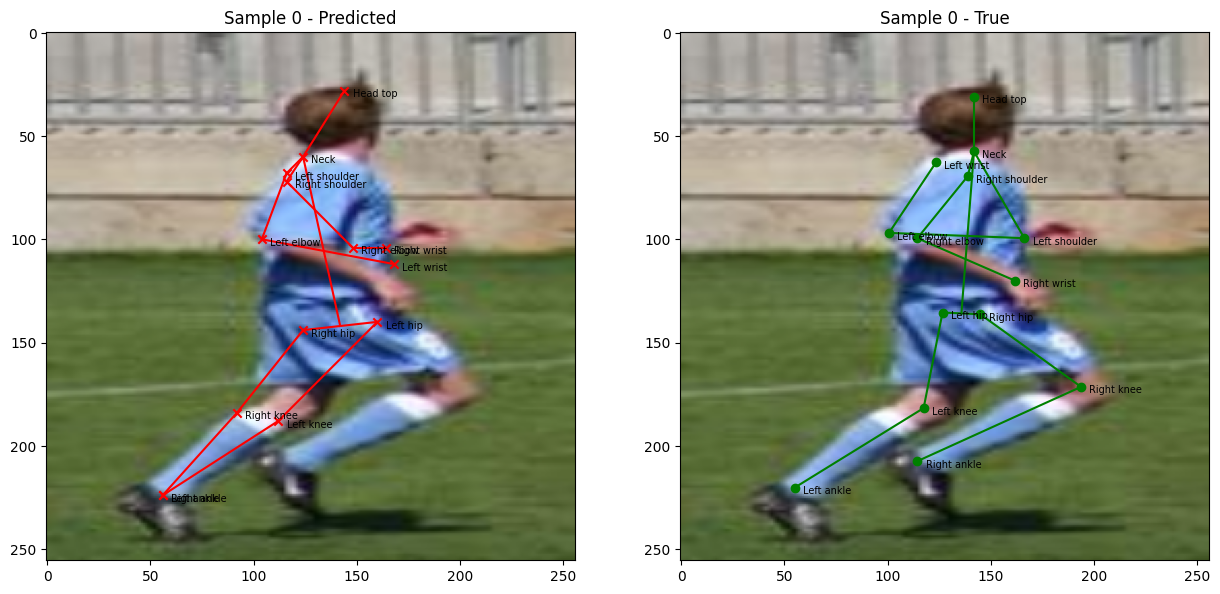

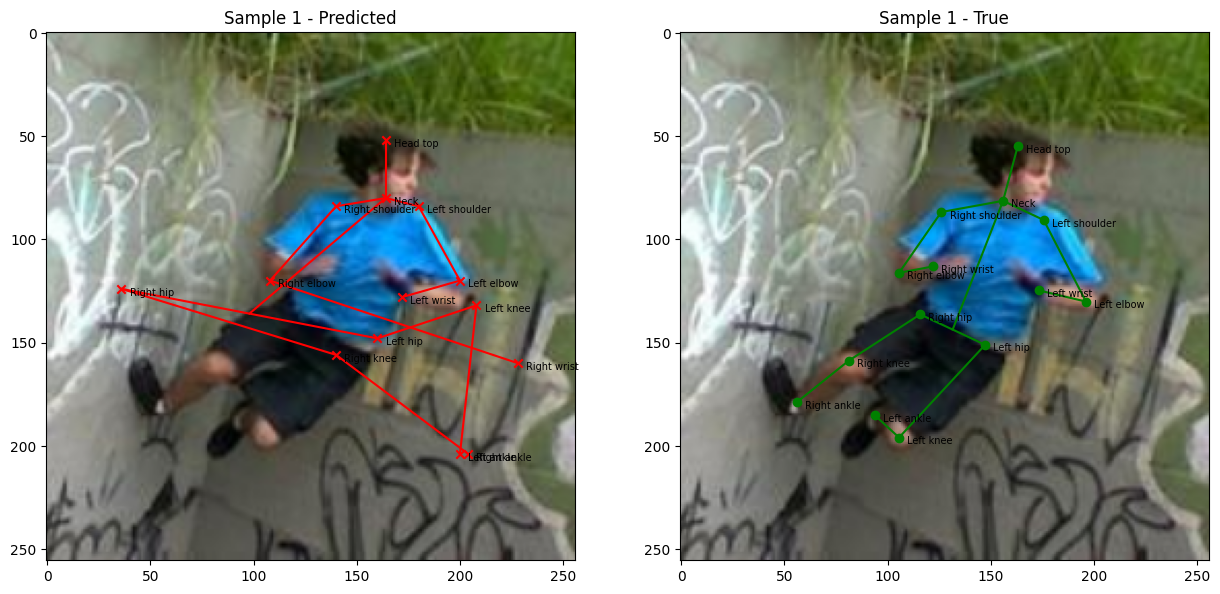

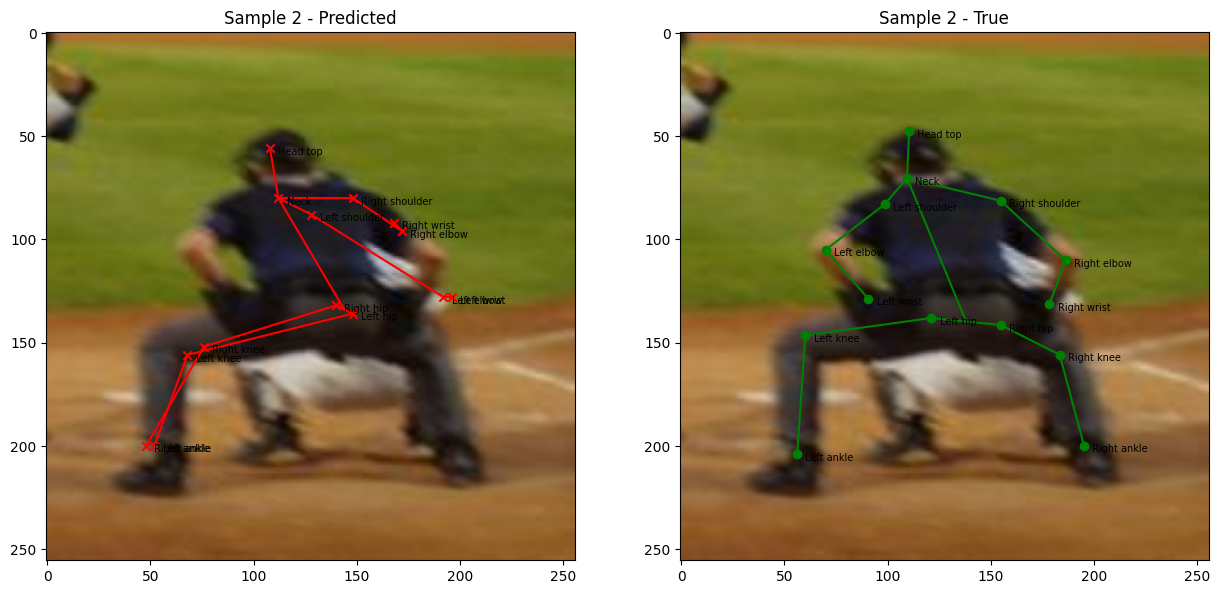

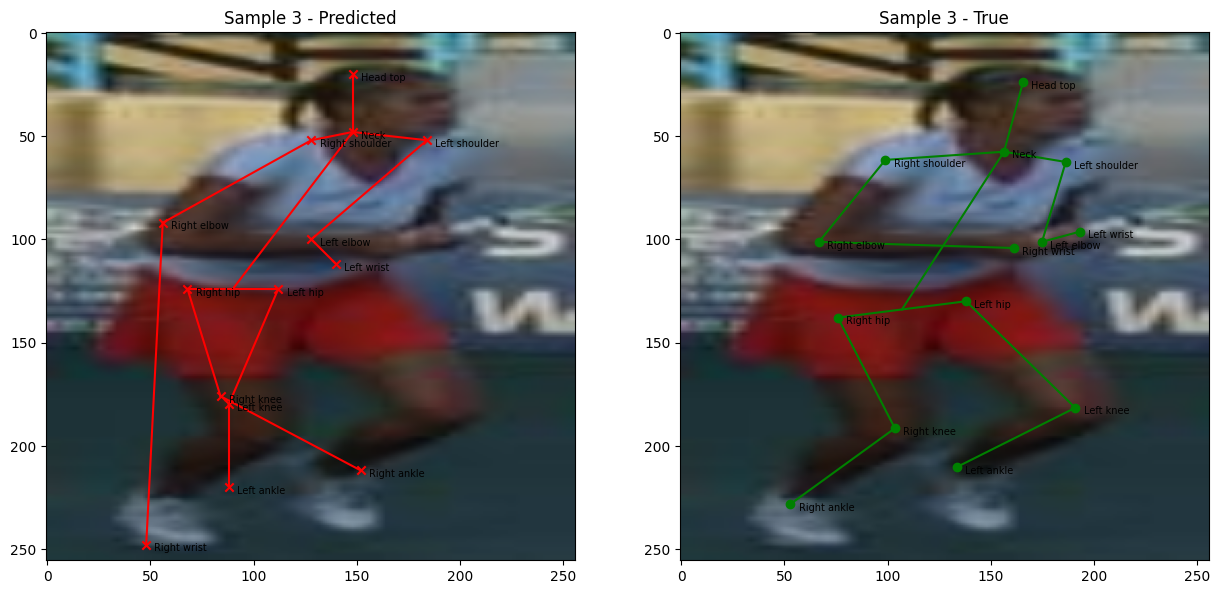

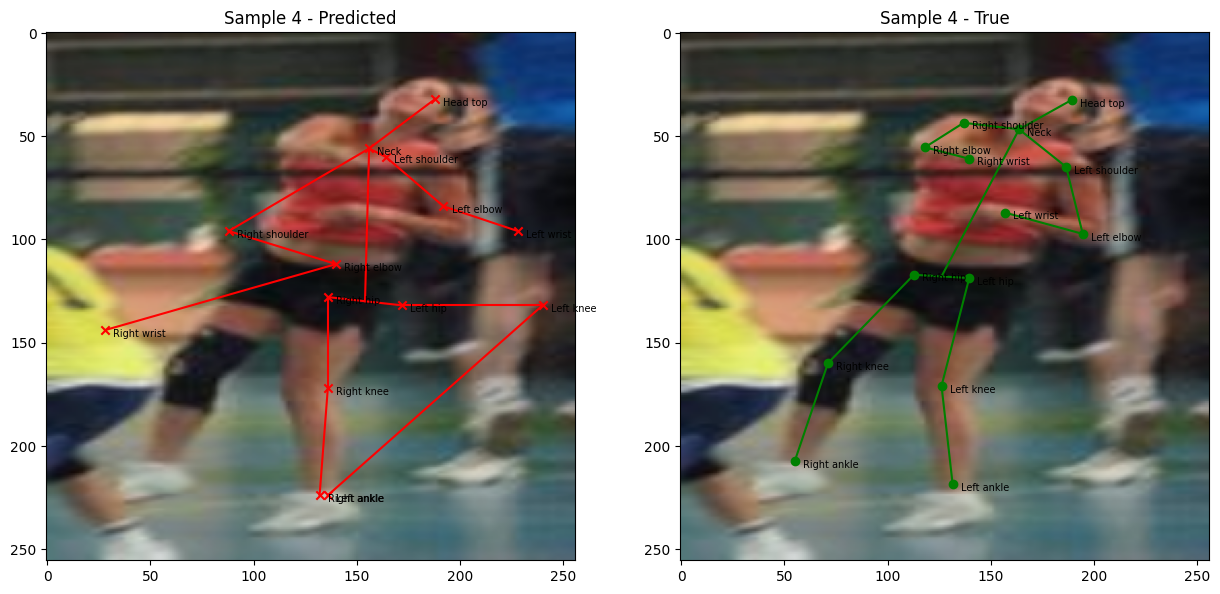

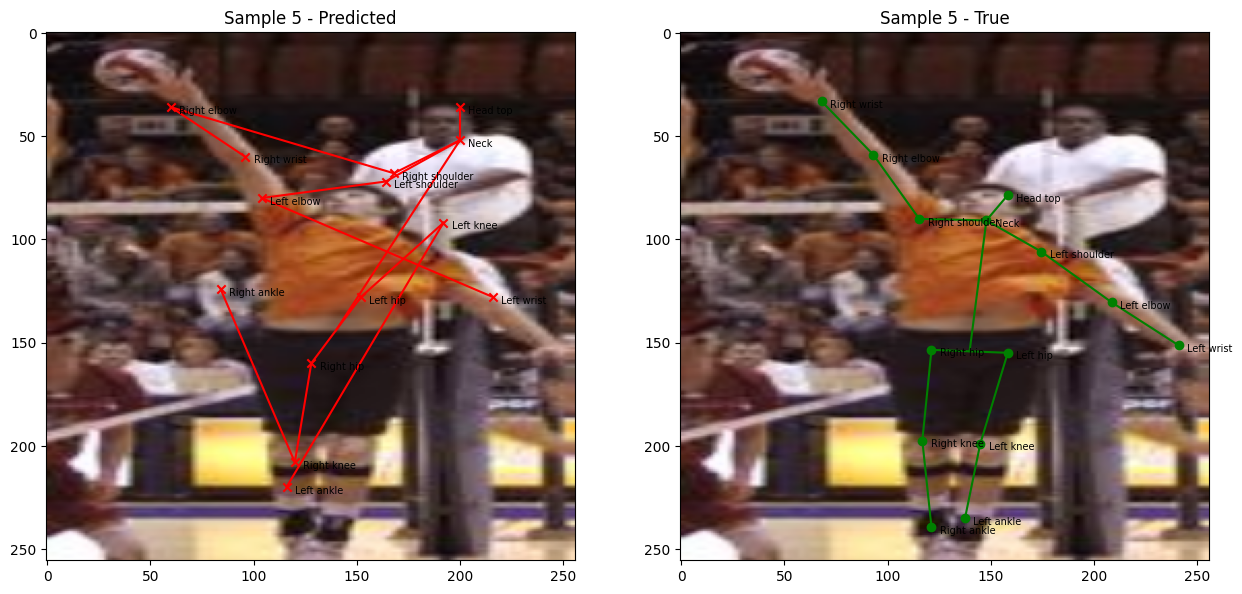

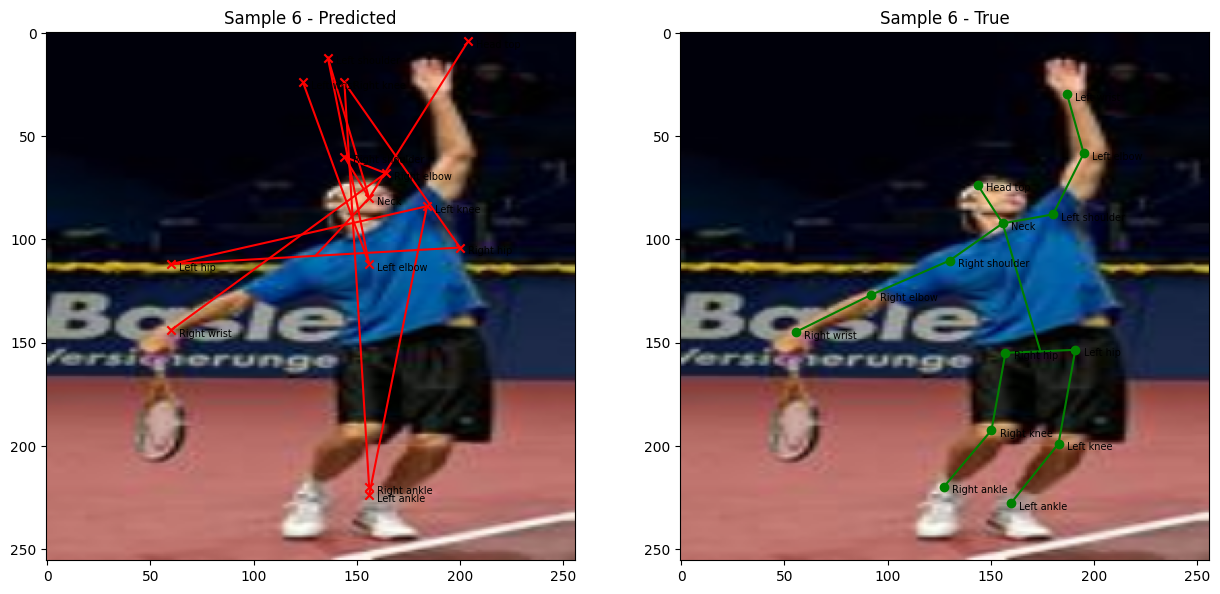

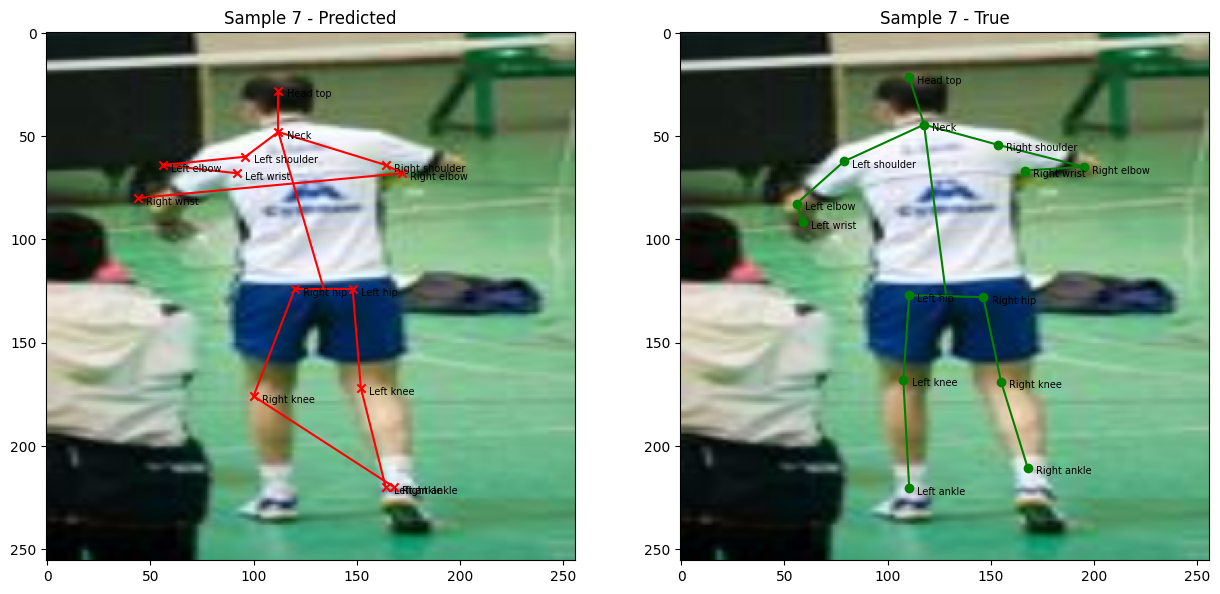

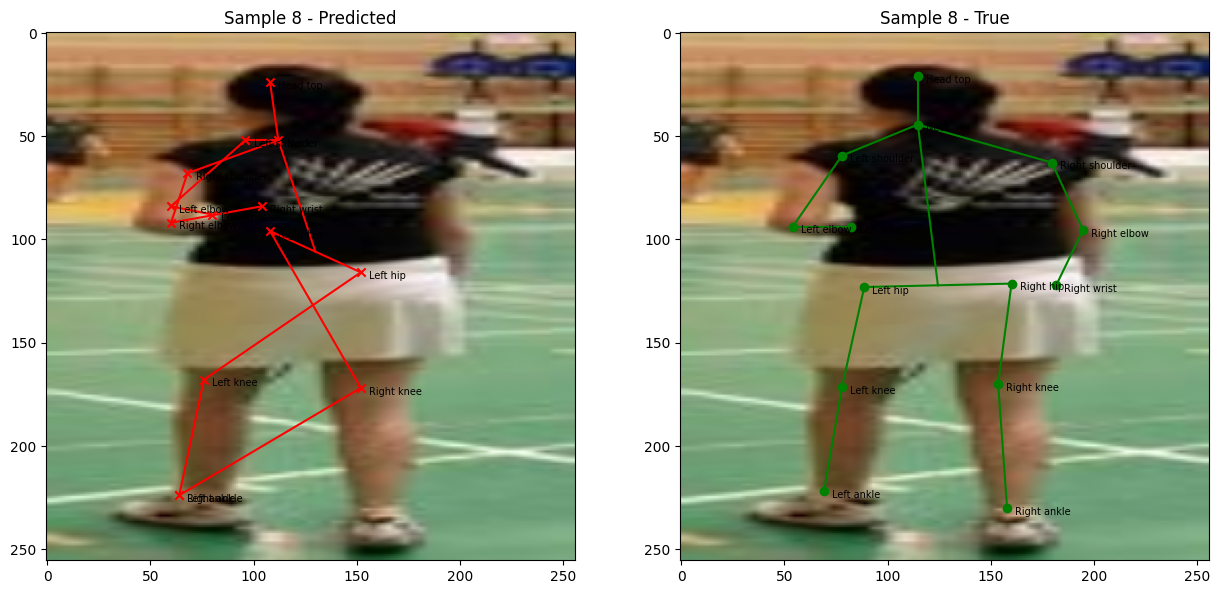

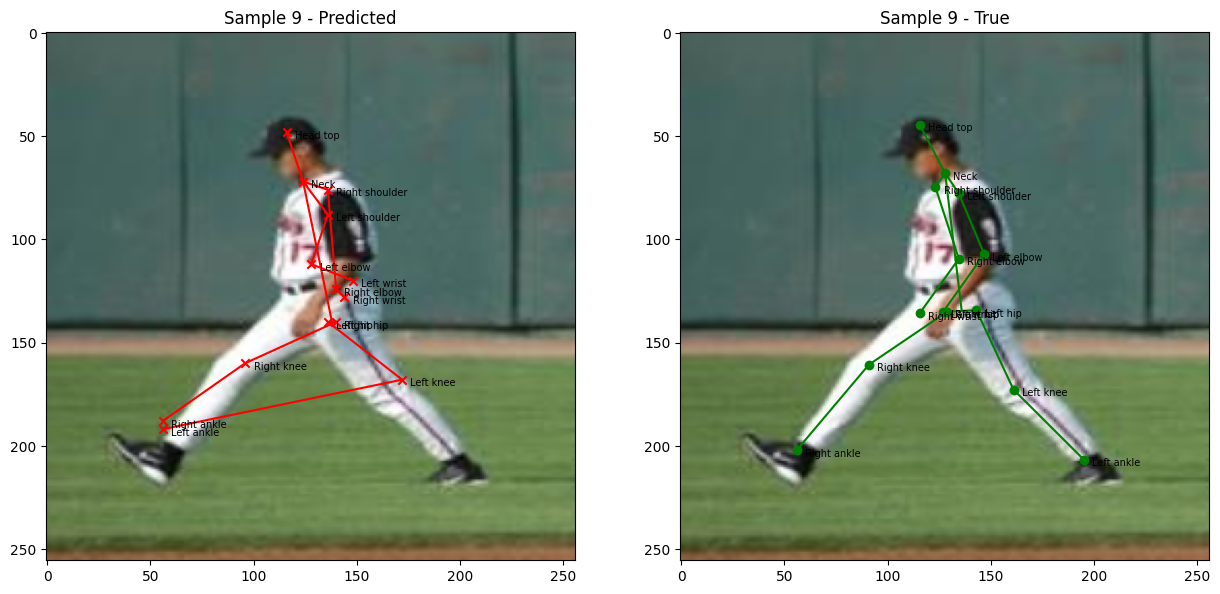

In [ ]:
# Visualize a prediction
visualize_prediction(joints_predictions, test, joints, skeleton, idxs=range(10))  # Change idx to view different samples

## Saving the Model (and accuracies)

In [ ]:
def save_model(model, optimizer, filename="pose_estimation_model_out.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)
    print(f"Model saved to {filename}")

In [ ]:
# Save the model
filename = "pose_estimation_model_out.pth"
save_model(model, optimizer, filename)

Model saved to pose_estimation_model_out.pth


In [ ]:
acc_filename = "accuracies_training"
np.savetxt(acc_filename, train_acc)

In [ ]:
acctest_filename = "accuracies_test"
np.savetxt(acctest_filename, acc_tot)

### Downloading saved models

In [ ]:
files.download(acc_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(acctest_filename)

In [ ]:
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>